In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import time
from Model import Residual_Unit
from Model import Attention_Block
from Model import AttentionResNet56_mini

In [2]:
print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)

TF version:  2.0.0
Keras version: 2.2.4-tf


In [3]:
from IPython.display import SVG
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,TensorBoard
from tensorflow.keras.models import load_model

## cifar10 data

In [4]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
x_train = x_train[:5000, :, :, :]
y_train = y_train[:5000]
x_test = x_test[:1000, :, :, :]
y_test = y_test[:1000]

# Input image dimensions.
input_shape = x_train.shape[1:]
print('input image shape:', input_shape)

# # resize image
# start = time.time()

# temp = []
# for i in range(1000):
#     temp.append(skimage.transform.resize(x_train[i,:,:,:], (224, 224), mode='constant'))
    
# x_train = np.array(temp).reshape((-1, 224, 224, 3))
    
# temp = []
# for i in range(200):
#     temp.append(skimage.transform.resize(x_test[i,:,:,:], (224, 224), mode='constant'))
    
# x_test = np.array(temp).reshape((-1, 224, 224, 3))

# end = time.time()
# print("Time taken by above cell is {}.".format((end-start)/60))
    
# # Preprocessing: subtract the mean value across every dimension for training data
# mean_image = np.mean(x_train, axis=0)
# mean_image_test = np.mean(x_test, axis=0)

# x_train = x_train.astype('float32') - mean_image.astype('float32')
# x_test = x_test.astype('float32') - mean_image_test

# x_train = x_train / 255
# x_test = x_test / 255

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

input image shape: (32, 32, 3)
x_train shape: (5000, 32, 32, 3)
y_train shape: (5000, 1)
x_test shape: (1000, 32, 32, 3)
y_test shape: (1000, 1)


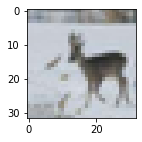

In [6]:
fig = plt.figure(figsize=(2,2))

plt.imshow(x_train[20,:,:,:])
plt.show()

In [7]:
# define generators for training and validation data
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_datagen.fit(x_train)
val_datagen.fit(x_train)

In [8]:
# build a model
model = AttentionResNet56_mini(shape=(32,32,3), in_channel=32, kernel_size=5, skip=2, n_classes=10, dropout=0.3, regularization=0.01)

# prepare usefull callbacks
# lr_reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=7, min_lr=10e-7, epsilon=0.01, verbose=1)
# early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1)
# callbacks= [lr_reducer, early_stopper]

# define loss, metrics, optimizer
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
batch_size = 128
epc = 15

start = time.time()

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
step_size_train = train_generator.n // train_generator.batch_size
test_generator = val_datagen.flow(x_test, y_test, batch_size=batch_size)
step_size_test = test_generator.n // test_generator.batch_size

log_dir='logs/'.format(int(time.time()))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit_generator(train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = epc, workers = 4,
                    validation_data = test_generator,
                    validation_steps = step_size_test,
                    callbacks=[tensorboard_callback])

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Epoch 1/15
39/39 [==============================] - 362s 9s/step - loss: 4.3935 - accuracy: 0.2040 - val_loss: 2.4122 - val_accuracy: 0.1663
Epoch 2/15
39/39 [==============================] - 365s 9s/step - loss: 2.4442 - accuracy: 0.2890 - val_loss: 2.4459 - val_accuracy: 0.1942
Epoch 3/15
39/39 [==============================] - 365s 9s/step - loss: 2.2615 - accuracy: 0.3239 - val_loss: 2.7160 - val_accuracy: 0.1663
Epoch 4/15
39/39 [==============================] - 365s 9s/step - loss: 2.1815 - accuracy: 0.3264 - val_loss: 2.6212 - val_accuracy: 0.1797
Epoch 5/15
39/39 [==============================] - 373s 10s/step - loss: 2.0400 - accuracy: 0.3526 - val_loss: 2.9135 - val_accuracy: 0.1473
Epoch 6/15
39/39 [==============================] - 359s 9s/step - loss: 1.9975 - accuracy: 0.3664 - val_loss: 2.6609 - val_accuracy: 0.2221
Epoch 7/15
39/39 [==============================] - 368s 9s/step - loss: 2.1231 - accuracy: 0.3543 - val_loss: 2.4764 - val_accuracy: 0.2500
Epoch 8/15
3

In [17]:
# model.evaluate_generator(val_datagen.flow(x_test, y_test), steps=len(x_test)/128, use_multiprocessing=True)

scores = model.evaluate(test_generator, steps=step_size_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

7/7 [==============================] - 6s 800ms/step - loss: 1.7281 - accuracy: 0.4520
Test loss: 1.7281078440802438
Test accuracy: 0.45200893


In [11]:
model.save('Model_15eps.h5')
# tf.keras.models.load_model('Model_15eps.h5')

## Zhaoyang

In [ ]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10
subtract_pixel_mean = True
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()
print(model_type)


# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])